## Markdown

In [1]:
import requests
import pandas as pd

# Replace with your actual API key
API_KEY = 'BxghlKSast8cBIZ3pNDsAUN4dtO1faSP'
API_key_weather = '1c37968bc1e6a8842d2785a8e6b0e52e'
lat, lon = 10.8231, 106.6297  # Coordinates for Ho Chi Minh City

# Define the URL for traffic data (e.g., Traffic Flow Data)
url = f"https://api.tomtom.com/traffic/services/flowSegmentData?point={lat},{lon}&unit=KMPH&key={API_KEY}"
url_weather = f"https://api.openweathermap.org/data/2.5/weather?lat={lat}&lon={lon}&appid={API_key_weather}"
# Make the API request
response = requests.get(url)
traffic_data = response.json()  # Get the response in JSON format

weather_response = requests.get(url_weather)
weather_data = weather_response.json()

traffic_data
weather_data

{'cod': 401,
 'message': 'Invalid API key. Please see https://openweathermap.org/faq#error401 for more info.'}

In [2]:
# HCMC Traffic Pattern Prediction - Data Collection
# This notebook collects traffic and weather data for Ho Chi Minh City

# Import necessary libraries
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import time
import json
import os

# Set up visualization style
plt.style.use('default')
sns.set_palette("husl")
%matplotlib inline

# Set your API keys here (you'll need to sign up for these services)
TOMTOM_API_KEY = "ZLhH20PVZkOu63eSrlNGz81QAzPA9WEi"
OPENWEATHER_API_KEY = "1c37968bc1e6a8842d2785a8e6b0e52e"

# Coordinates for key locations in HCMC
hcmc_locations = {
    "District_1": {"lat": 10.7757, "lon": 106.7009},
    "Thu_Thiem": {"lat": 10.7835, "lon": 106.7215},
    "Tan_Son_Nhat": {"lat": 10.8181, "lon": 106.6519},
    "Binh_Thanh": {"lat": 10.8106, "lon": 106.7091},
    "Phu_My_Hung": {"lat": 10.7272, "lon": 106.7057}
}

In [3]:
# Function to get traffic data from TomTom API
def get_tomtom_traffic_data(lat, lon, api_key, save_to_file=True):
    """
    Fetch traffic data from TomTom API for a specific location in HCMC
    """
    url = "https://api.tomtom.com/traffic/services/4/flowSegmentData/absolute/10/json"
    
    params = {
        'point': f"{lat},{lon}",
        'unit': 'KMPH',
        'key': api_key,
        'zoom': 12
    }
    
    try:
        response = requests.get(url, params=params)
        response.raise_for_status()  # Raise an exception for bad status codes
        data = response.json()
        
        if save_to_file:
            # Create directory if it doesn't exist
            os.makedirs('traffic_data', exist_ok=True)
            
            timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
            filename = f"traffic_data/tomtom_traffic_{lat}_{lon}_{timestamp}.json"
            with open(filename, 'w') as f:
                json.dump(data, f, indent=2)
        
        return data
        
    except requests.exceptions.RequestException as e:
        print(f"Error fetching traffic data: {e}")
        return None

# Collect traffic data for all locations
traffic_data = {}
for name, coords in hcmc_locations.items():
    print(f"Fetching traffic data for {name}...")
    data = get_tomtom_traffic_data(coords["lat"], coords["lon"], TOMTOM_API_KEY)
    if data:
        traffic_data[name] = data
    time.sleep(1)  # Be nice to the API

print("Traffic data collection completed!")

Fetching traffic data for District_1...
Fetching traffic data for Thu_Thiem...
Fetching traffic data for Tan_Son_Nhat...
Fetching traffic data for Binh_Thanh...
Fetching traffic data for Phu_My_Hung...
Traffic data collection completed!


In [4]:
# Function to get weather data from OpenWeatherMap API
def get_weather_data(lat, lon, api_key, save_to_file=True):
    """
    Fetch current weather data from OpenWeatherMap API for HCMC
    """
    url = "https://api.openweathermap.org/data/2.5/weather"
    
    params = {
        'lat': lat,
        'lon': lon,
        'appid': api_key,
        'units': 'metric'
    }
    
    try:
        response = requests.get(url, params=params)
        response.raise_for_status()
        data = response.json()
        
        if save_to_file:
            os.makedirs('weather_data', exist_ok=True)
            
            timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
            filename = f"weather_data/weather_{lat}_{lon}_{timestamp}.json"
            with open(filename, 'w') as f:
                json.dump(data, f, indent=2)
        
        return data
        
    except requests.exceptions.RequestException as e:
        print(f"Error fetching weather data: {e}")
        return None

# Get weather data for central HCMC
print("Fetching weather data for HCMC...")
weather_data = get_weather_data(10.7757, 106.7009, OPENWEATHER_API_KEY)
print("Weather data collection completed!")

Fetching weather data for HCMC...
Weather data collection completed!


In [5]:
# Process traffic data into a DataFrame
def process_traffic_data(traffic_dict):
    processed_data = []
    
    for location, data in traffic_dict.items():
        if data and 'flowSegmentData' in data:
            segment = data['flowSegmentData']
            processed_data.append({
                'location': location,
                'latitude': hcmc_locations[location]["lat"],
                'longitude': hcmc_locations[location]["lon"],
                'current_speed': segment['currentSpeed'],
                'free_flow_speed': segment['freeFlowSpeed'],
                'current_travel_time': segment['currentTravelTime'],
                'free_flow_travel_time': segment['freeFlowTravelTime'],
                'confidence': segment['confidence'],
                'road_closure': segment['roadClosure'],
                'timestamp': datetime.now().strftime("%Y-%m-%d %H:%M:%S")
            })
    
    return pd.DataFrame(processed_data)

# Process weather data into a DataFrame
def process_weather_data(weather_dict):
    if not weather_dict:
        return pd.DataFrame()
    
    return pd.DataFrame([{
        'temperature': weather_dict['main']['temp'],
        'feels_like': weather_dict['main']['feels_like'],
        'humidity': weather_dict['main']['humidity'],
        'pressure': weather_dict['main']['pressure'],
        'wind_speed': weather_dict['wind']['speed'],
        'wind_deg': weather_dict['wind'].get('deg', None),
        'cloudiness': weather_dict['clouds']['all'],
        'visibility': weather_dict.get('visibility', None),
        'weather_main': weather_dict['weather'][0]['main'],
        'weather_description': weather_dict['weather'][0]['description'],
        'rain_1h': weather_dict.get('rain', {}).get('1h', 0) if 'rain' in weather_dict else 0,
        'timestamp': datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    }])

# Process our collected data
traffic_df = process_traffic_data(traffic_data)
weather_df = process_weather_data(weather_data)

# Display the data
print("Traffic Data:")
display(traffic_df.head())

print("\nWeather Data:")
display(weather_df.head())

Traffic Data:


,location,latitude,longitude,current_speed,free_flow_speed,current_travel_time,free_flow_travel_time,confidence,road_closure,timestamp
0,District_1,10.7757,106.7009,17,25,48,33,1,False,2025-09-17 05:09:01
1,Thu_Thiem,10.7835,106.7215,40,40,204,204,1,False,2025-09-17 05:09:01
2,Tan_Son_Nhat,10.8181,106.6519,31,31,1210,1210,1,False,2025-09-17 05:09:01
3,Binh_Thanh,10.8106,106.7091,20,33,326,197,1,False,2025-09-17 05:09:01
4,Phu_My_Hung,10.7272,106.7057,38,41,964,893,1,False,2025-09-17 05:09:01



Weather Data:


,temperature,feels_like,humidity,pressure,wind_speed,wind_deg,cloudiness,visibility,weather_main,weather_description,rain_1h,timestamp
0,28.88,34.83,82,1010,2.57,280,75,10000,Clouds,broken clouds,0,2025-09-17 05:09:01


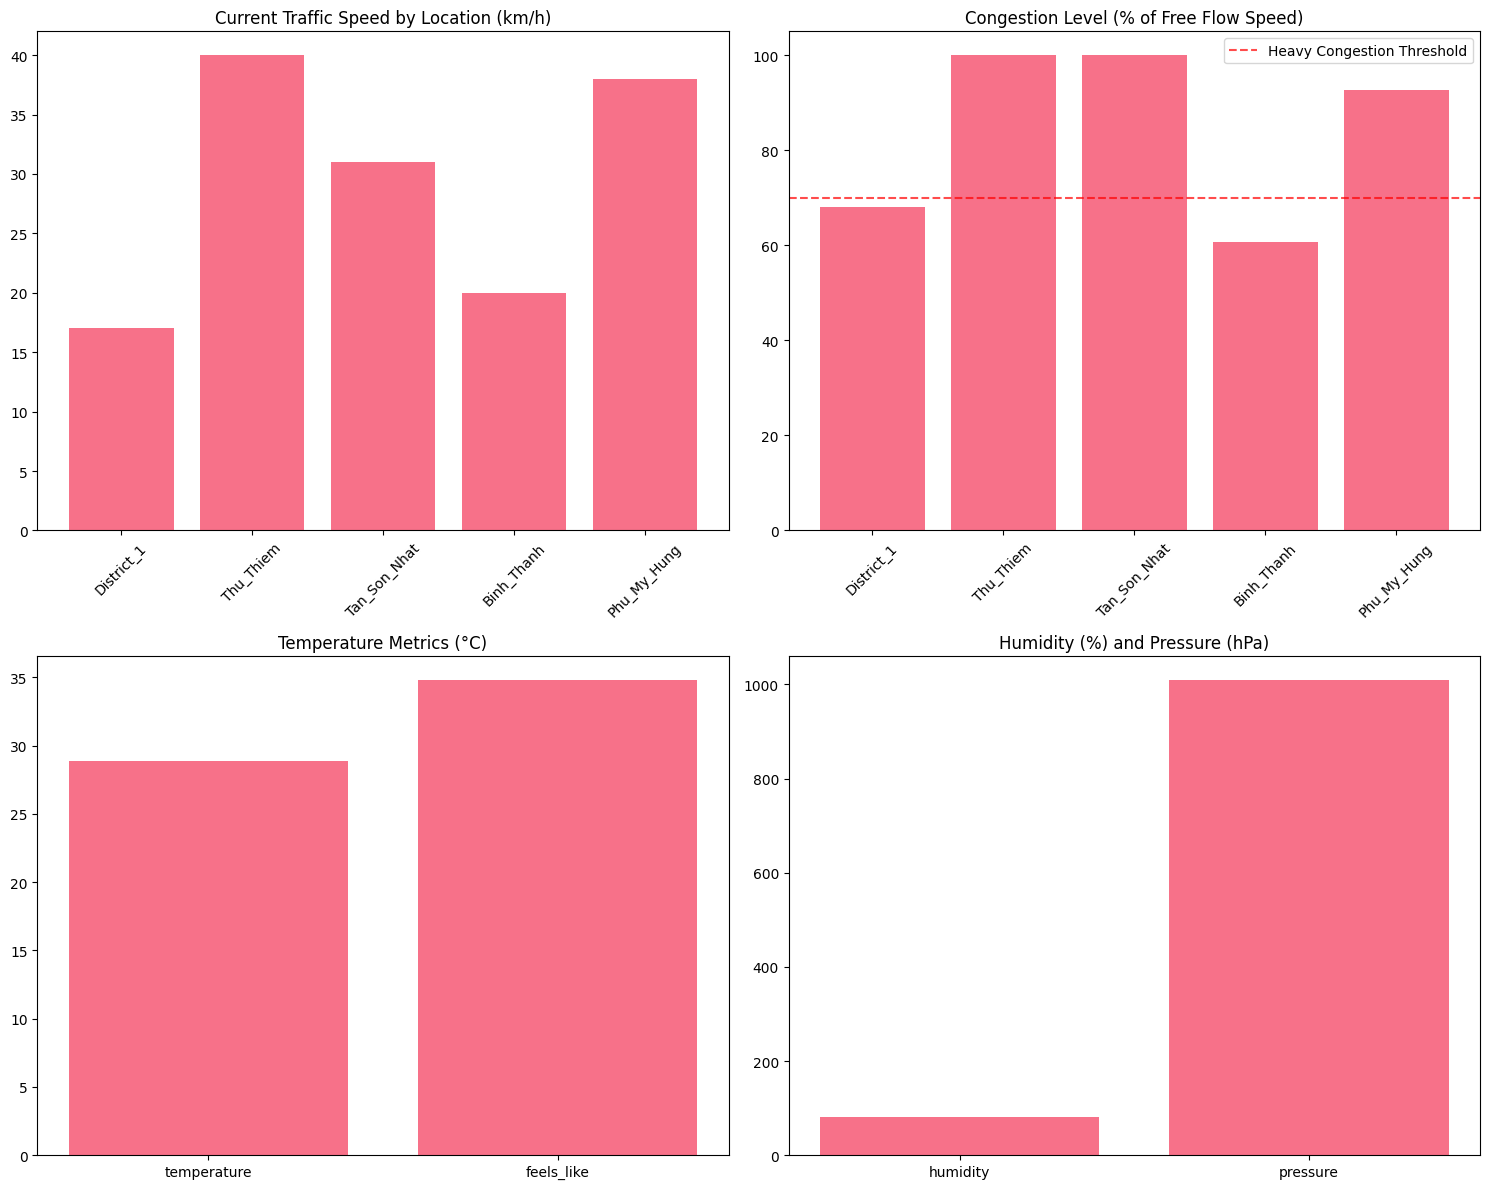

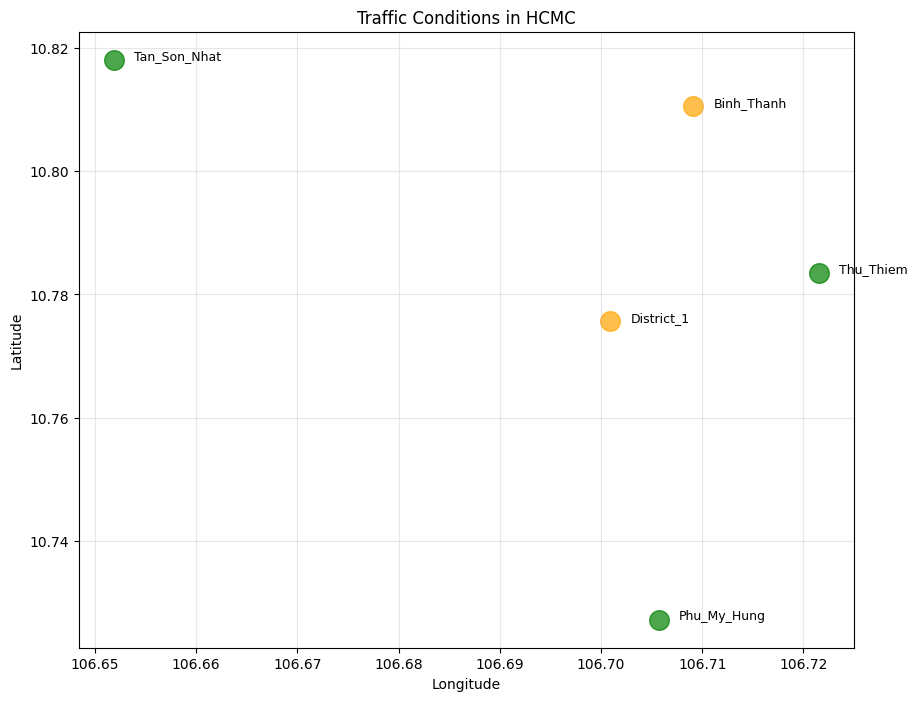

In [6]:
# Create visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Traffic speed by location
if not traffic_df.empty:
    axes[0, 0].bar(traffic_df['location'], traffic_df['current_speed'])
    axes[0, 0].set_title('Current Traffic Speed by Location (km/h)')
    axes[0, 0].tick_params(axis='x', rotation=45)
    
    # Congestion level (current speed as % of free flow speed)
    traffic_df['congestion_level'] = (traffic_df['current_speed'] / traffic_df['free_flow_speed']) * 100
    axes[0, 1].bar(traffic_df['location'], traffic_df['congestion_level'])
    axes[0, 1].set_title('Congestion Level (% of Free Flow Speed)')
    axes[0, 1].tick_params(axis='x', rotation=45)
    axes[0, 1].axhline(y=70, color='r', linestyle='--', alpha=0.7, label='Heavy Congestion Threshold')
    axes[0, 1].legend()

# Weather data visualization
if not weather_df.empty:
    # Temperature and feels like
    weather_metrics = ['temperature', 'feels_like']
    values = [weather_df.iloc[0][m] for m in weather_metrics]
    axes[1, 0].bar(weather_metrics, values)
    axes[1, 0].set_title('Temperature Metrics (°C)')
    
    # Humidity and pressure
    weather_metrics2 = ['humidity', 'pressure']
    values2 = [weather_df.iloc[0][m] for m in weather_metrics2]
    axes[1, 1].bar(weather_metrics2, values2)
    axes[1, 1].set_title('Humidity (%) and Pressure (hPa)')

plt.tight_layout()
plt.show()

# Create a map visualization of traffic conditions
if not traffic_df.empty:
    plt.figure(figsize=(10, 8))
    
    # Plot each location with color based on congestion level
    for _, row in traffic_df.iterrows():
        congestion = row['congestion_level']
        if congestion > 70:
            color = 'green'  # Good traffic
        elif congestion > 50:
            color = 'orange'  # Moderate traffic
        else:
            color = 'red'  # Heavy traffic
            
        plt.scatter(row['longitude'], row['latitude'], c=color, s=200, alpha=0.7)
        plt.text(row['longitude']+0.002, row['latitude'], row['location'], fontsize=9)
    
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('Traffic Conditions in HCMC')
    plt.grid(True, alpha=0.3)
    plt.show()